# Applying a bayesian workflow: lessons from Statistical Rethinking (I)

### 1) Exploratory data analysis and data transformation

In [4]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

az.style.use('arviz-darkgrid')

df = pd.read_csv('../data/raw/train.csv').loc[:, ['SalePrice', 'LotArea', 'Neighborhood']]

# Log transform
df['log_sales_price'] = np.log(df['SalePrice'])
df['log_lot_area'] = np.log(df['LotArea'])

# Create numerical categories (add 1 due to zero indexing)
df['neighbourhood'] = df['Neighborhood'].astype('category').cat.codes+1

df.head()

SalePrice  LotArea Neighborhood  log_sales_price  log_lot_area  \
0     208500     8450      CollgCr        12.247694      9.041922   
1     181500     9600      Veenker        12.109011      9.169518   
2     223500    11250      CollgCr        12.317167      9.328123   
3     140000     9550      Crawfor        11.849398      9.164296   
4     250000    14260      NoRidge        12.429216      9.565214   

   neighbourhood  
0              6  
1             25  
2              6  
3              7  
4             16

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


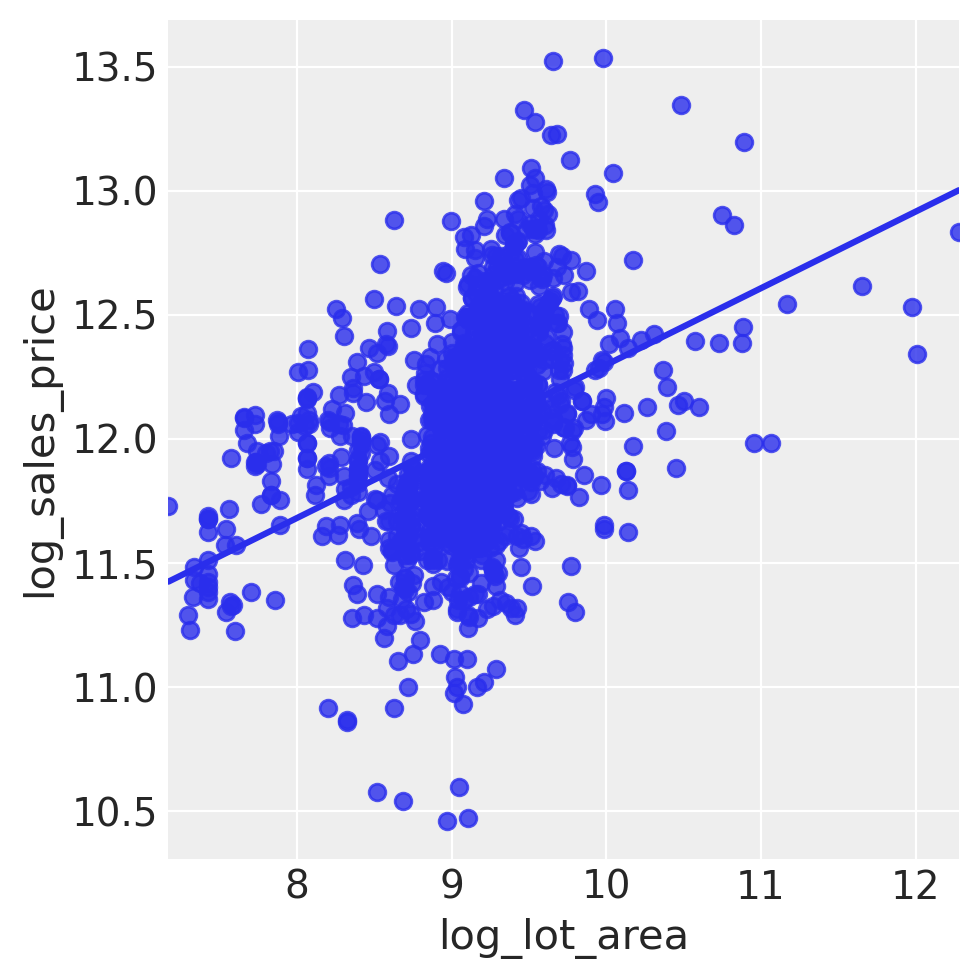

In [5]:
sns.lmplot(x='log_lot_area',y='log_sales_price',data=df,fit_reg=True, ci = False)
plt.tight_layout()


/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


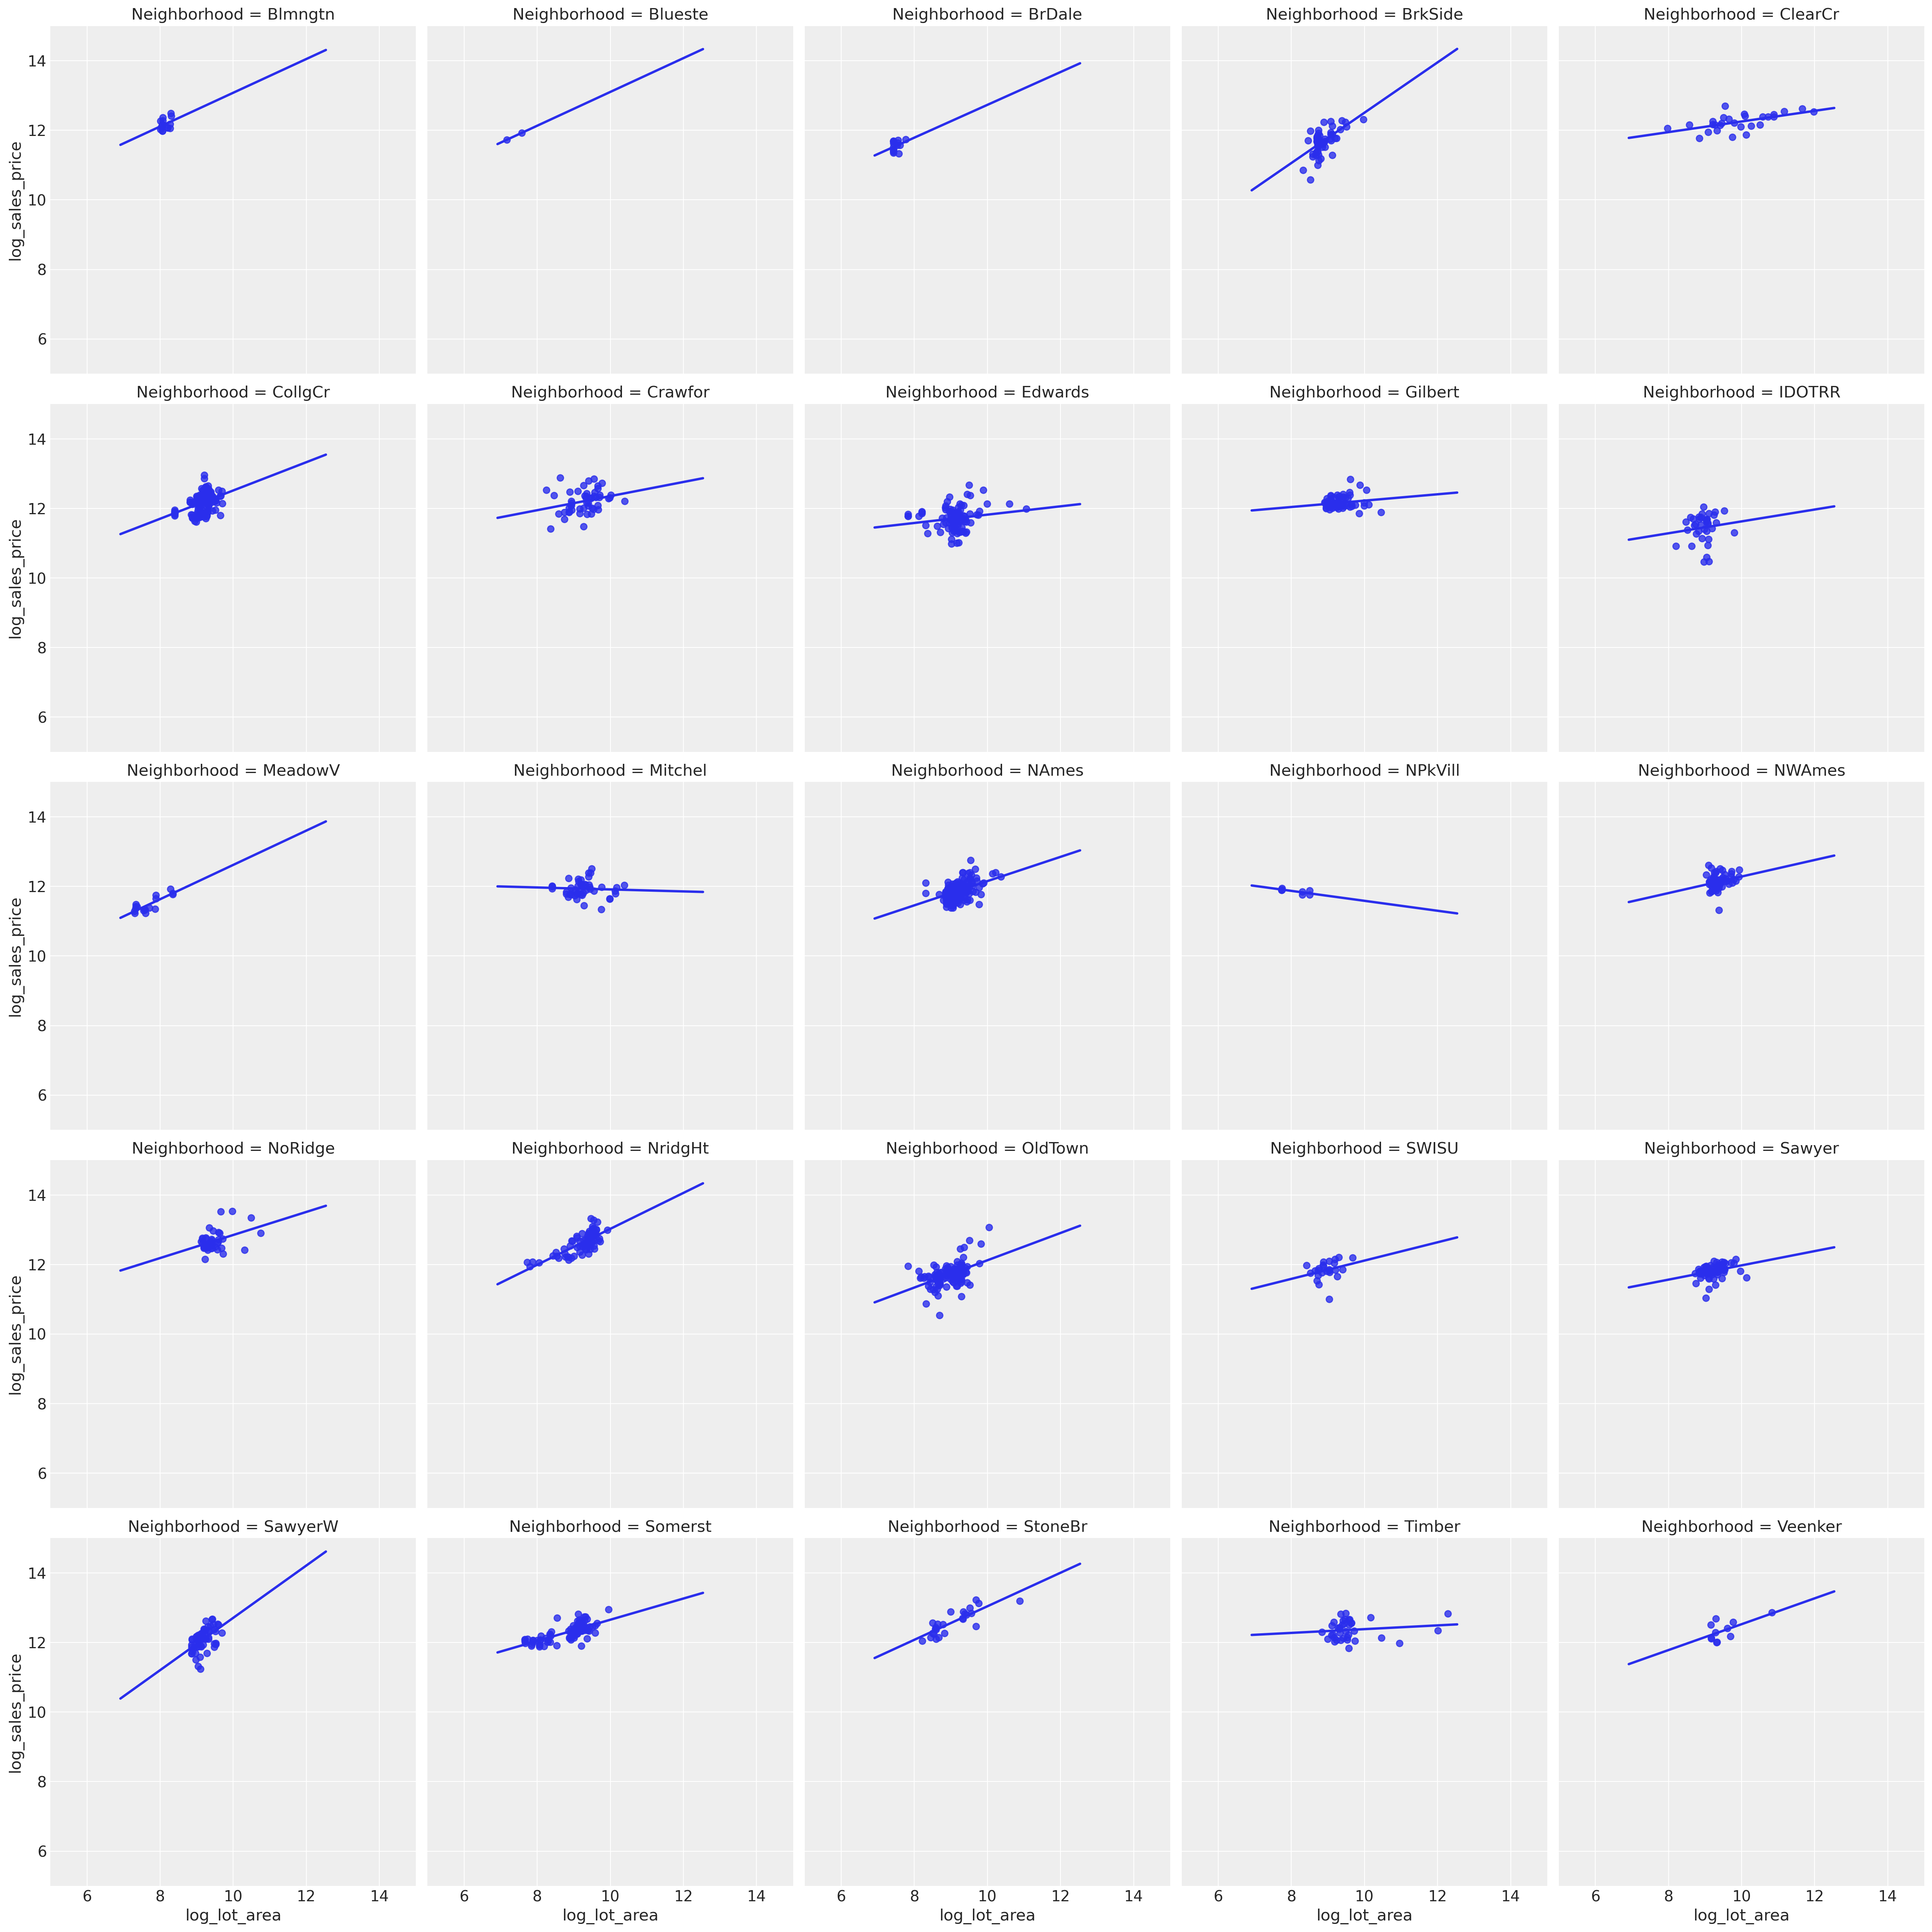

In [6]:
facet_scatter = sns.lmplot(x="log_lot_area", 
                           y="log_sales_price", 
                           col="Neighborhood",
                           col_wrap = 5,
                           data=df,
                           ci = None, 
                           truncate=False,
                           col_order = sorted(df['Neighborhood'].drop_duplicates()))

facet_scatter.set(xlim=(5, 15))
facet_scatter.set(ylim=(5, 15))

### 2) Write out full probability model

In [7]:
# Standardise predictors
def z_std(x):
    """
    Centres at mean 0 and standard deviation 1
    """
    z_score = (x - x.mean()) / x.std()
    return(z_score)
    
# Center and scale predictor
df['log_lot_area_z'] = z_std(df['log_lot_area'])

# Scale target
df['log_sales_price_z'] = z_std(df['log_sales_price'])

### 3)  Prior predictive checks - simulate data from the implied generative model

In [19]:
no_pooling_stan_code = '''
// No pooling model for predicting housing prices
data {
    // Fitting the model on training data
    int<lower=0> N; // Number of rows
    int<lower=0> neighbourhood[N]; // neighbourhood categorical variable
    int<lower=0> N_neighbourhood; // number of neighbourhood categories
    vector[N] log_sales_price; // log sales price
    vector[N] log_lot_area; // log lot area

    // Adjust scale parameters in python
    real alpha_sd;
    real beta_sd;
    
    // Set to zero for prior predictive checks, set to one to evaluate likelihood
    int<lower = 0, upper = 1> run_estimation;
}
parameters {
    vector[N_neighbourhood] alpha; // Vector of alpha coefficients for each neighbourhood
    real beta;
    real<lower=0> sigma;
}
model {
    // Priors
    target += normal_lpdf(alpha | 0, alpha_sd);
    target += normal_lpdf(beta | 0, beta_sd);
    target += exponential_lpdf(sigma |1);
    
    // Likelihood
    if(run_estimation==1){
        target += normal_lpdf(log_sales_price | alpha[neighbourhood] + beta * log_lot_area, sigma);

    }
}
generated quantities {
    // Uses fitted model to generate values of interest
    vector[N] log_lik; // Log likelihood
    vector[N] y_hat; // Predictions using training data
    {
    for(n in 1:N){
          log_lik[n] = normal_lpdf(log_sales_price | alpha[neighbourhood[n]] + beta * log_lot_area[n], sigma);
          y_hat[n] = normal_rng(alpha[neighbourhood[n]] + beta * log_lot_area[n], sigma);      
        }
    }
}
'''

# Dictionary contains all data inputs
npm_data_check = dict(N = len(df),
                      log_sales_price = df['log_sales_price_z'],
                      log_lot_area = df['log_lot_area_z'],
                      neighbourhood = df['neighbourhood'],
                      N_neighbourhood = len(df['neighbourhood'].unique()),
                      alpha_sd = 1, 
                      beta_sd = 1, 
                      run_estimation = 0)

# Compile stan model
no_pooling_model = pystan.StanModel(model_code = no_pooling_stan_code)

# Draw samples from joint prior distribution
fit_npm_check = no_pooling_model.sampling(data=npm_data_check, seed = 12345)

# Extract samples into a pandas dataframe
npm_df_check = fit_npm_check.to_dataframe()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_14f4fc944867a1a0ed7c8160d1d42f4f NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


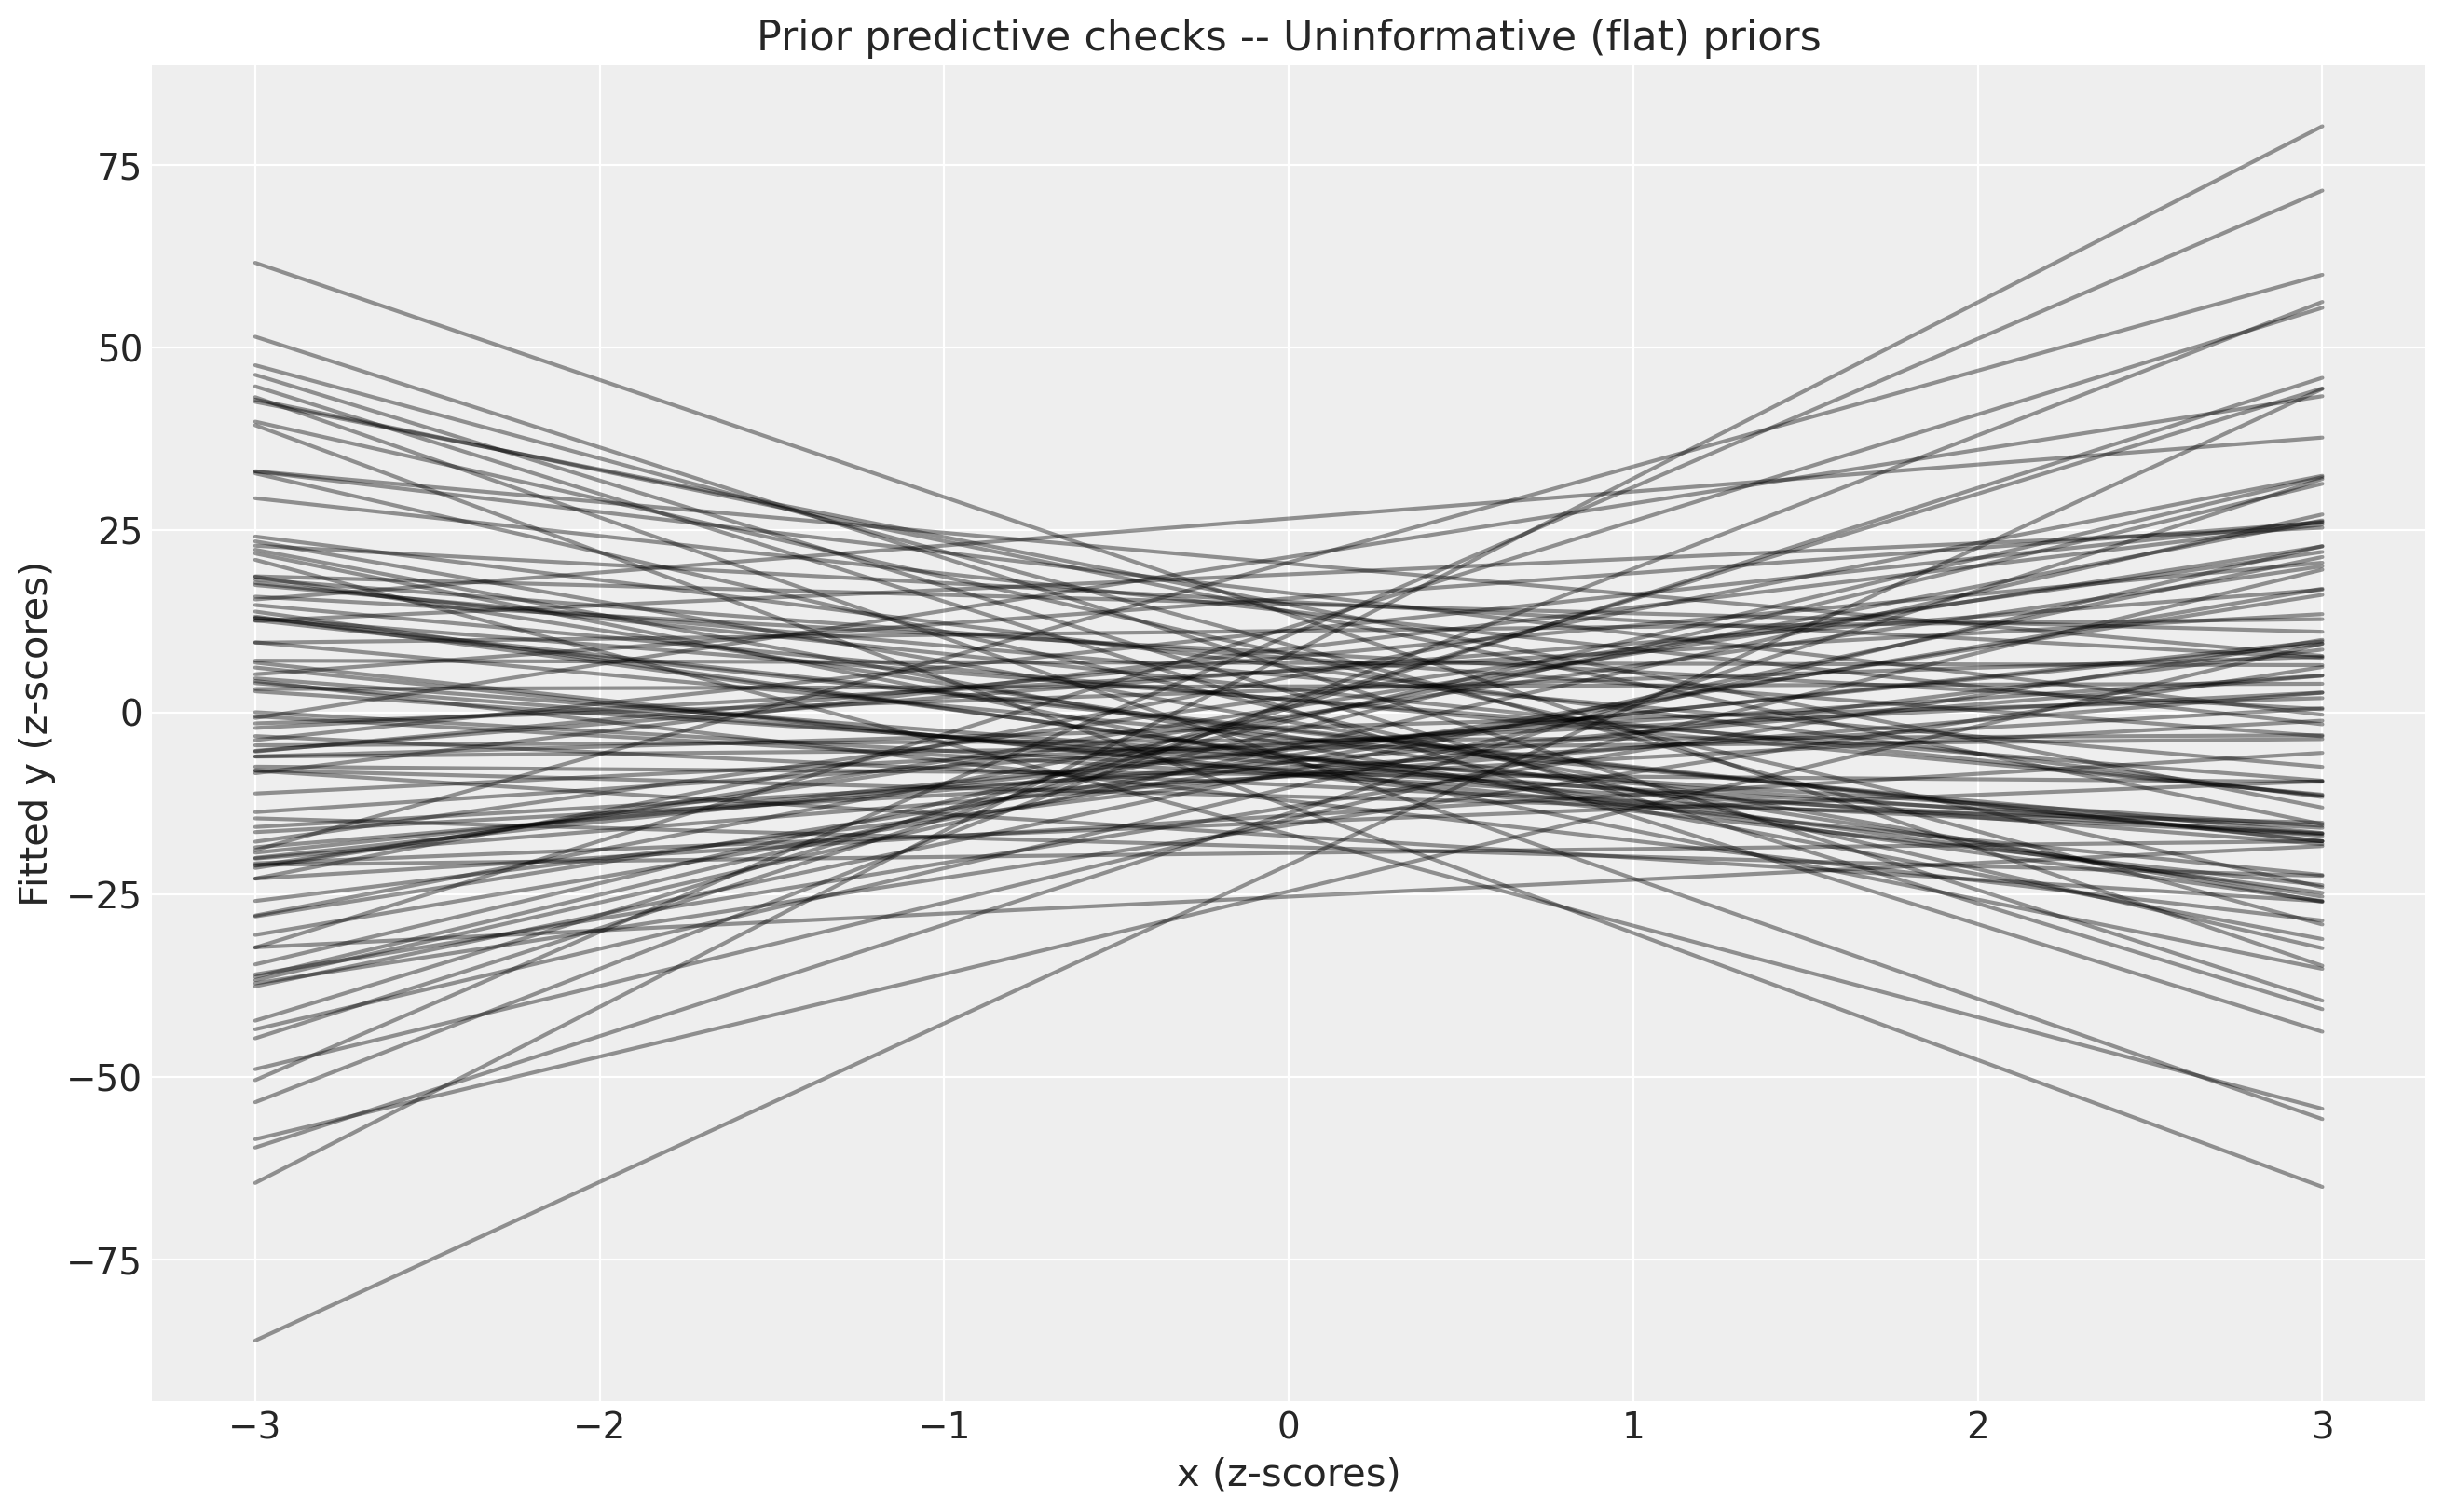

In [20]:
npm_data_check_wide = dict(N = len(df),
                      log_sales_price = df['log_sales_price_z'],
                      log_lot_area = df['log_lot_area_z'],
                      neighbourhood = df['neighbourhood'],
                      N_neighbourhood = len(df['Neighborhood'].unique()),
                      alpha_sd = 10, 
                      beta_sd = 10, 
                      run_estimation = 0)

fit_npm_check_wide = no_pooling_model.sampling(data=npm_data_check_wide, seed = 12345)
npm_df_check_wide = fit_npm_check_wide.to_dataframe()

_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, beta in zip(npm_df_check_wide["alpha[4]"][:100], npm_df_check_wide["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Uninformative (flat) priors");

Text(0.5, 1.0, 'Prior predictive checks -- Weakly regularizing priors')

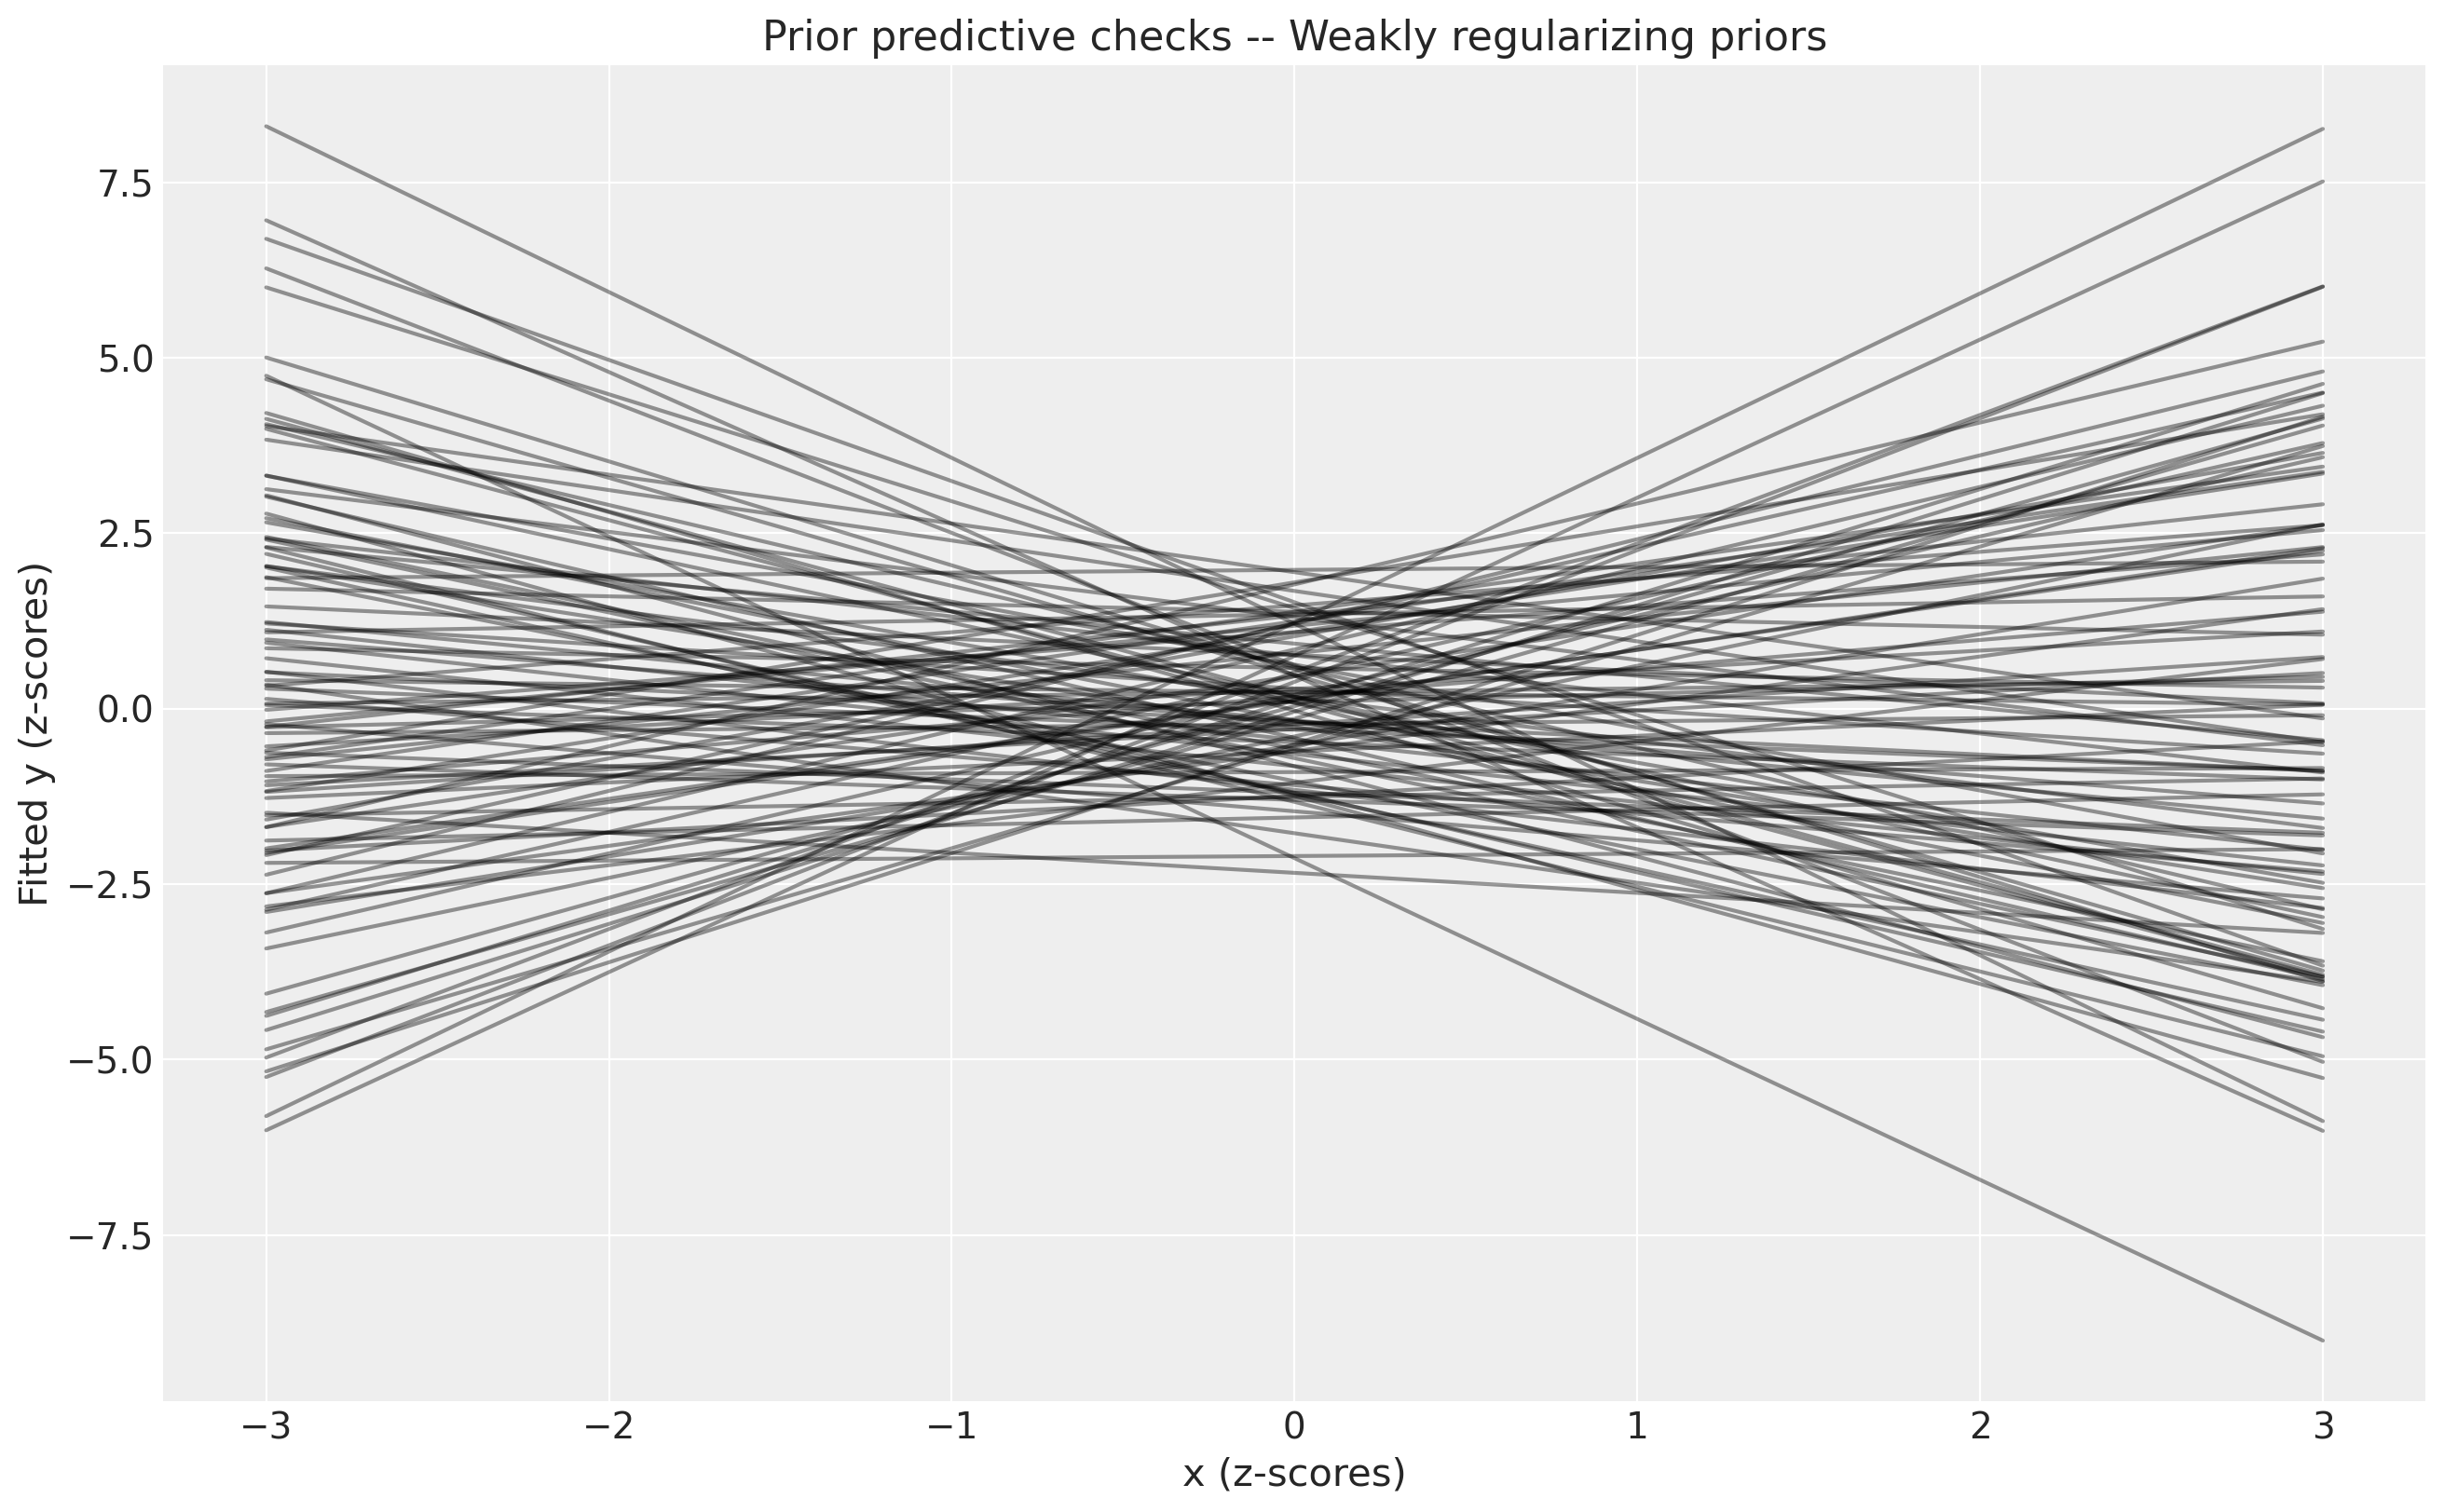

In [21]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, beta in zip(npm_df_check["alpha[4]"][:100], npm_df_check["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors")

### 4)  Fit model on fake data

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


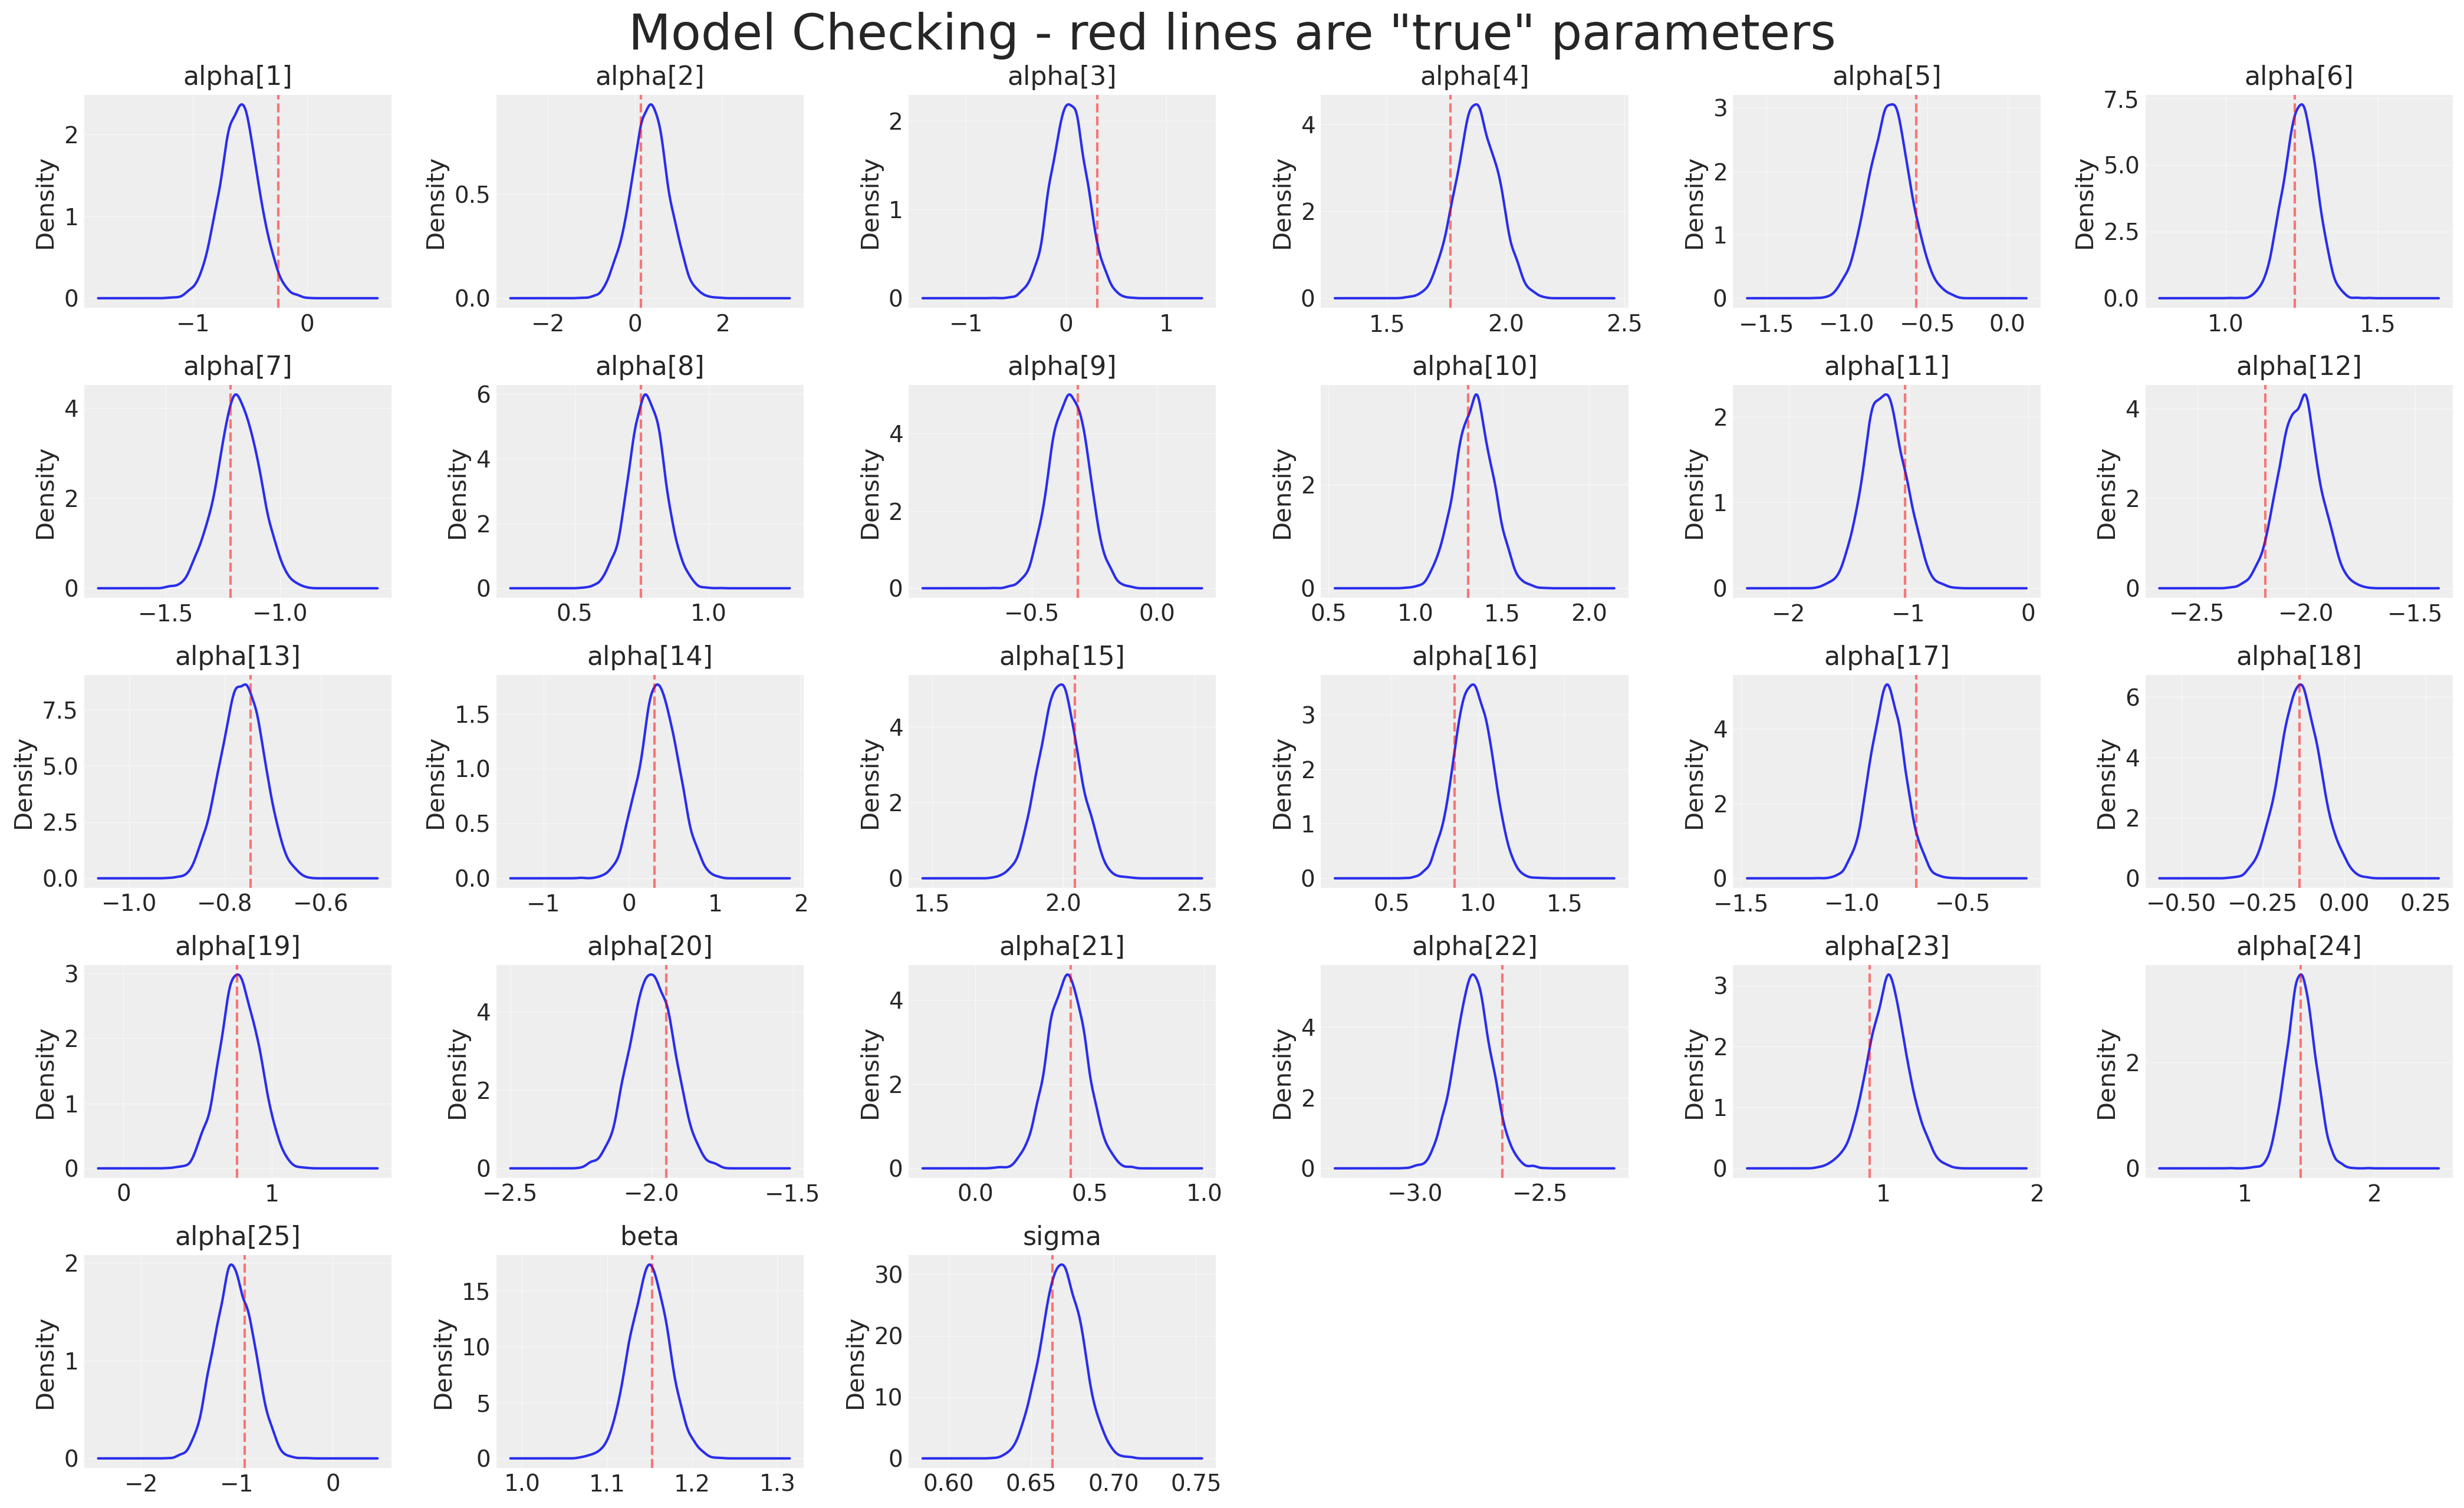

In [27]:
# Pick random simulation, let's say 10
random_draw = 50

# Extract the simulated (fake) data implied by the parameters in sample 10
y_sim = npm_df_check.filter(regex = 'y_hat').iloc[random_draw, :]

# Extract the parameteres corresponding to sample 10
true_parameters = npm_df_check.filter(regex = 'alpha|beta|sigma').iloc[random_draw, :]

# Fit the model on the fake data
_npm_data_check = dict(N = len(df),
              log_sales_price = y_sim, # this is now fitting on the extracted fake data in sample 10
              log_lot_area = df['log_lot_area_z'],
              neighbourhood = df['neighbourhood'],
              N_neighbourhood = len(df['Neighborhood'].unique()),
              alpha_sd = 1, 
              beta_sd = 1, 
              run_estimation = 1)

_fit_npm_check = no_pooling_model.sampling(data=_npm_data_check, seed = 12345)
_npm_df_check = _fit_npm_check.to_dataframe()
fake_fit = _npm_df_check.filter(regex = 'alpha|beta|sigma')
parameter_df = pd.melt(fake_fit)

# Plot will give distributions of all parameteres to see if it can capture the known parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking - red lines are "true" parameters', size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df[['variable']].drop_duplicates().set_index('variable').index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

### 5)  Estimate model on real data

In [26]:
# Dictionary with data inputs - set run_estimation=1
npm_data = dict(N = len(df),
              log_sales_price = df['log_sales_price_z'],
              log_lot_area = df['log_lot_area_z'],
              neighbourhood = df['neighbourhood'],
              N_neighbourhood = len(df['Neighborhood'].unique()),
              alpha_sd = 1, 
              beta_sd = 1, 
              run_estimation = 1)

# Fit model by sampling from posterior distribution
fit_npm = no_pooling_model.sampling(data=npm_data)

# For generating viusalisations using the arviz package
npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

# Extract samples into dataframe
fit_npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### 6) Check whether MCMC sampler and model fit

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

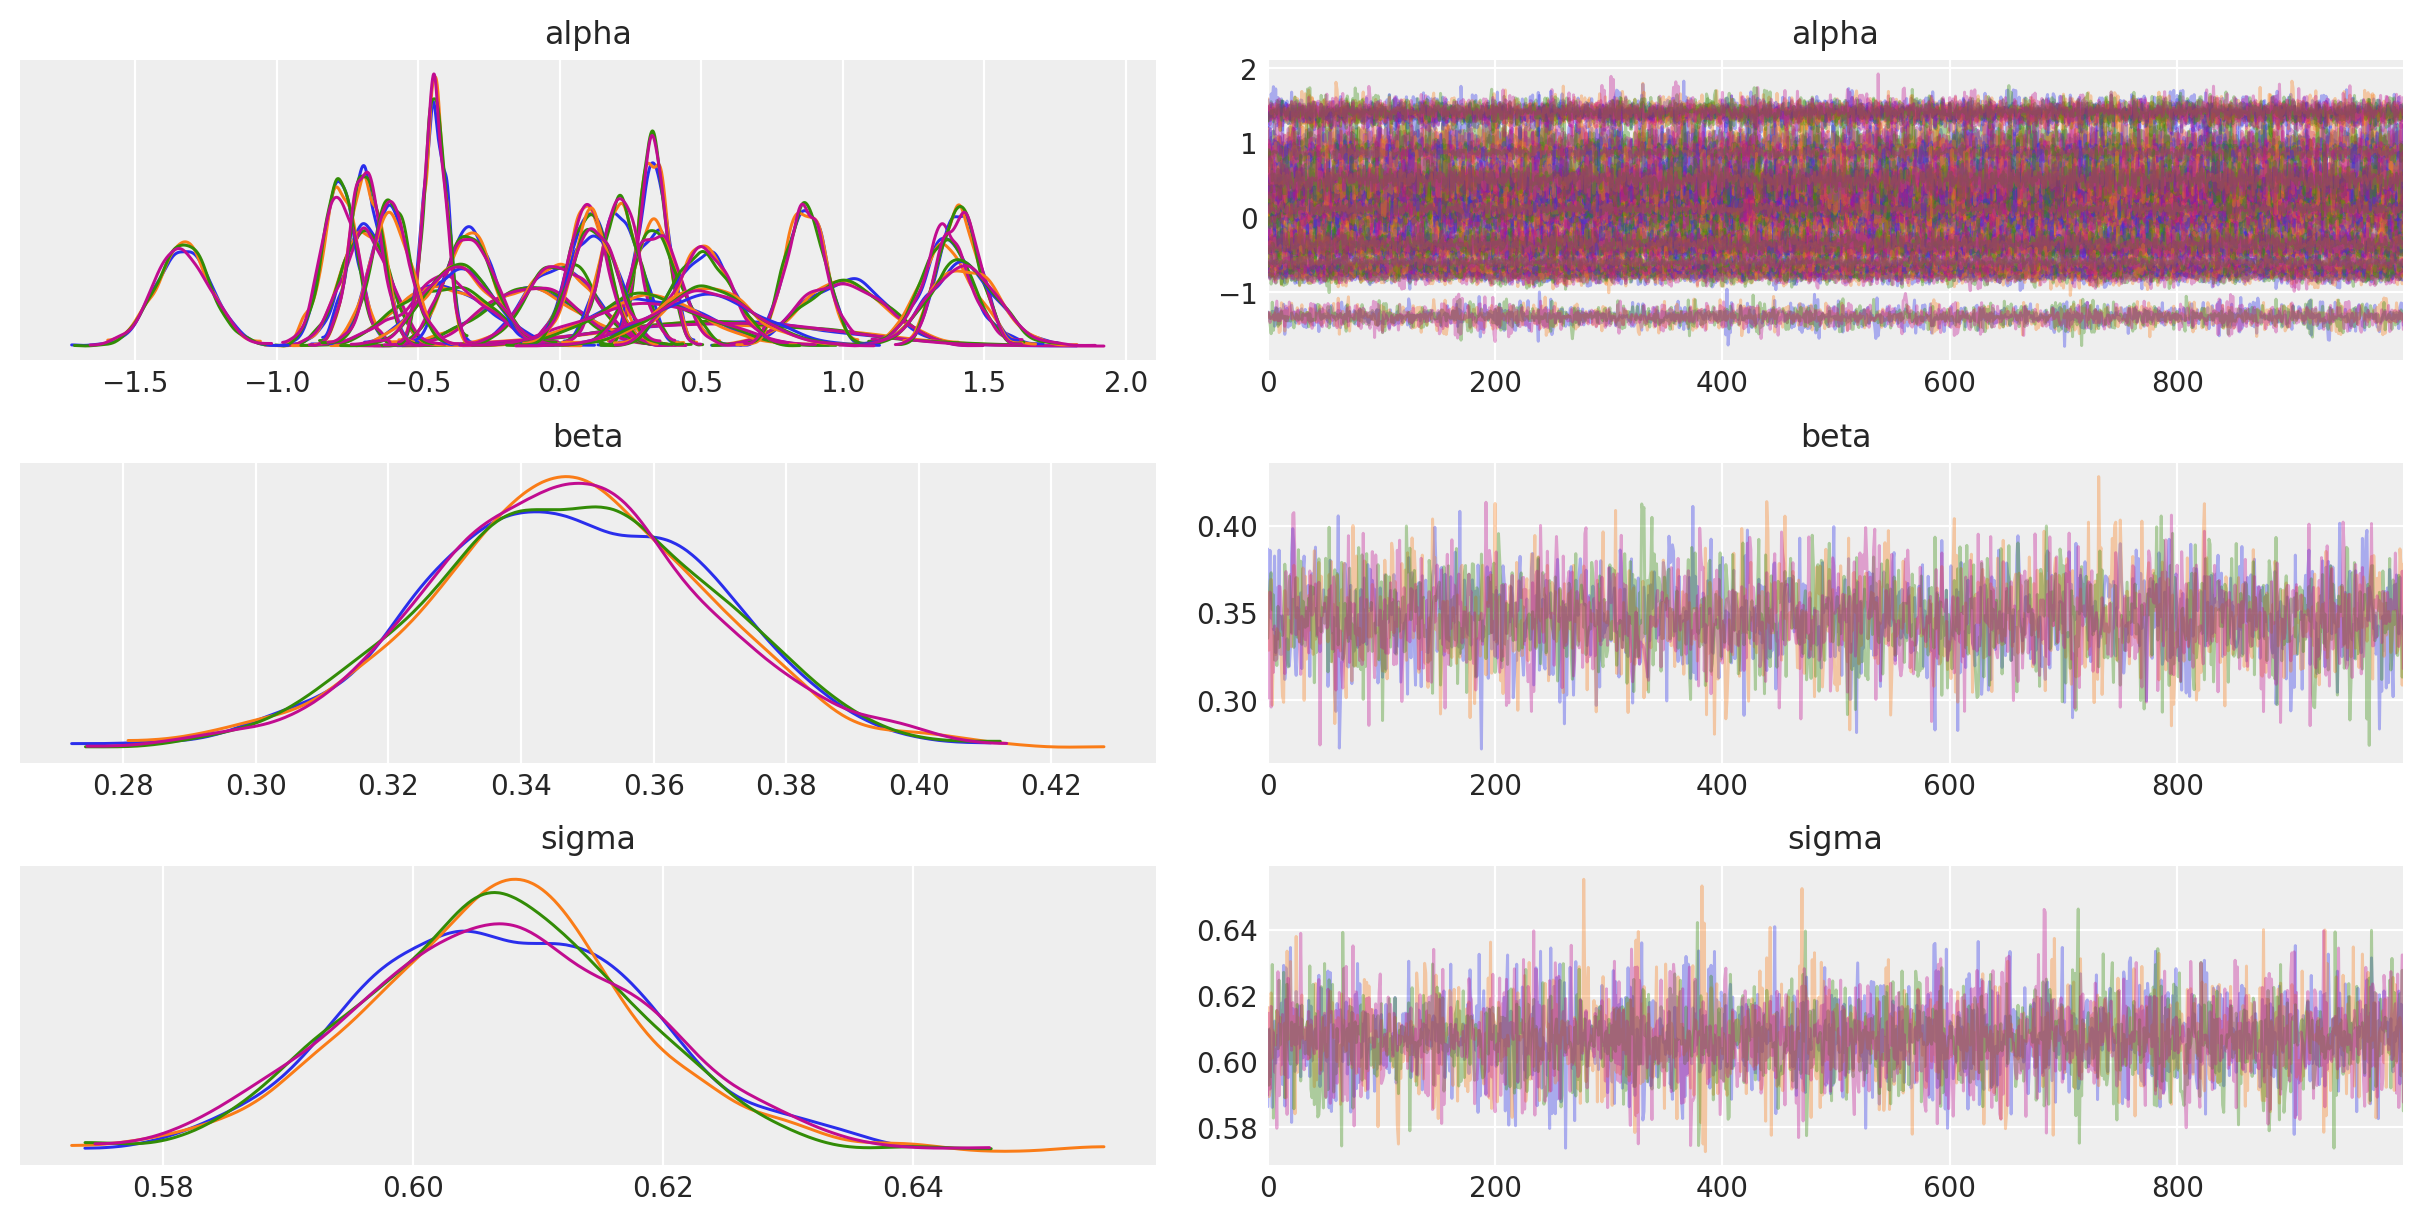

In [28]:
# Inspect model fit
az.plot_trace(fit_npm, 
              var_names=["alpha", "beta", "sigma"], 
              compact = True, 
              chain_prop = 'color')

Text(0.5, 1.0, 'Posterior distributions of fitted parameters')

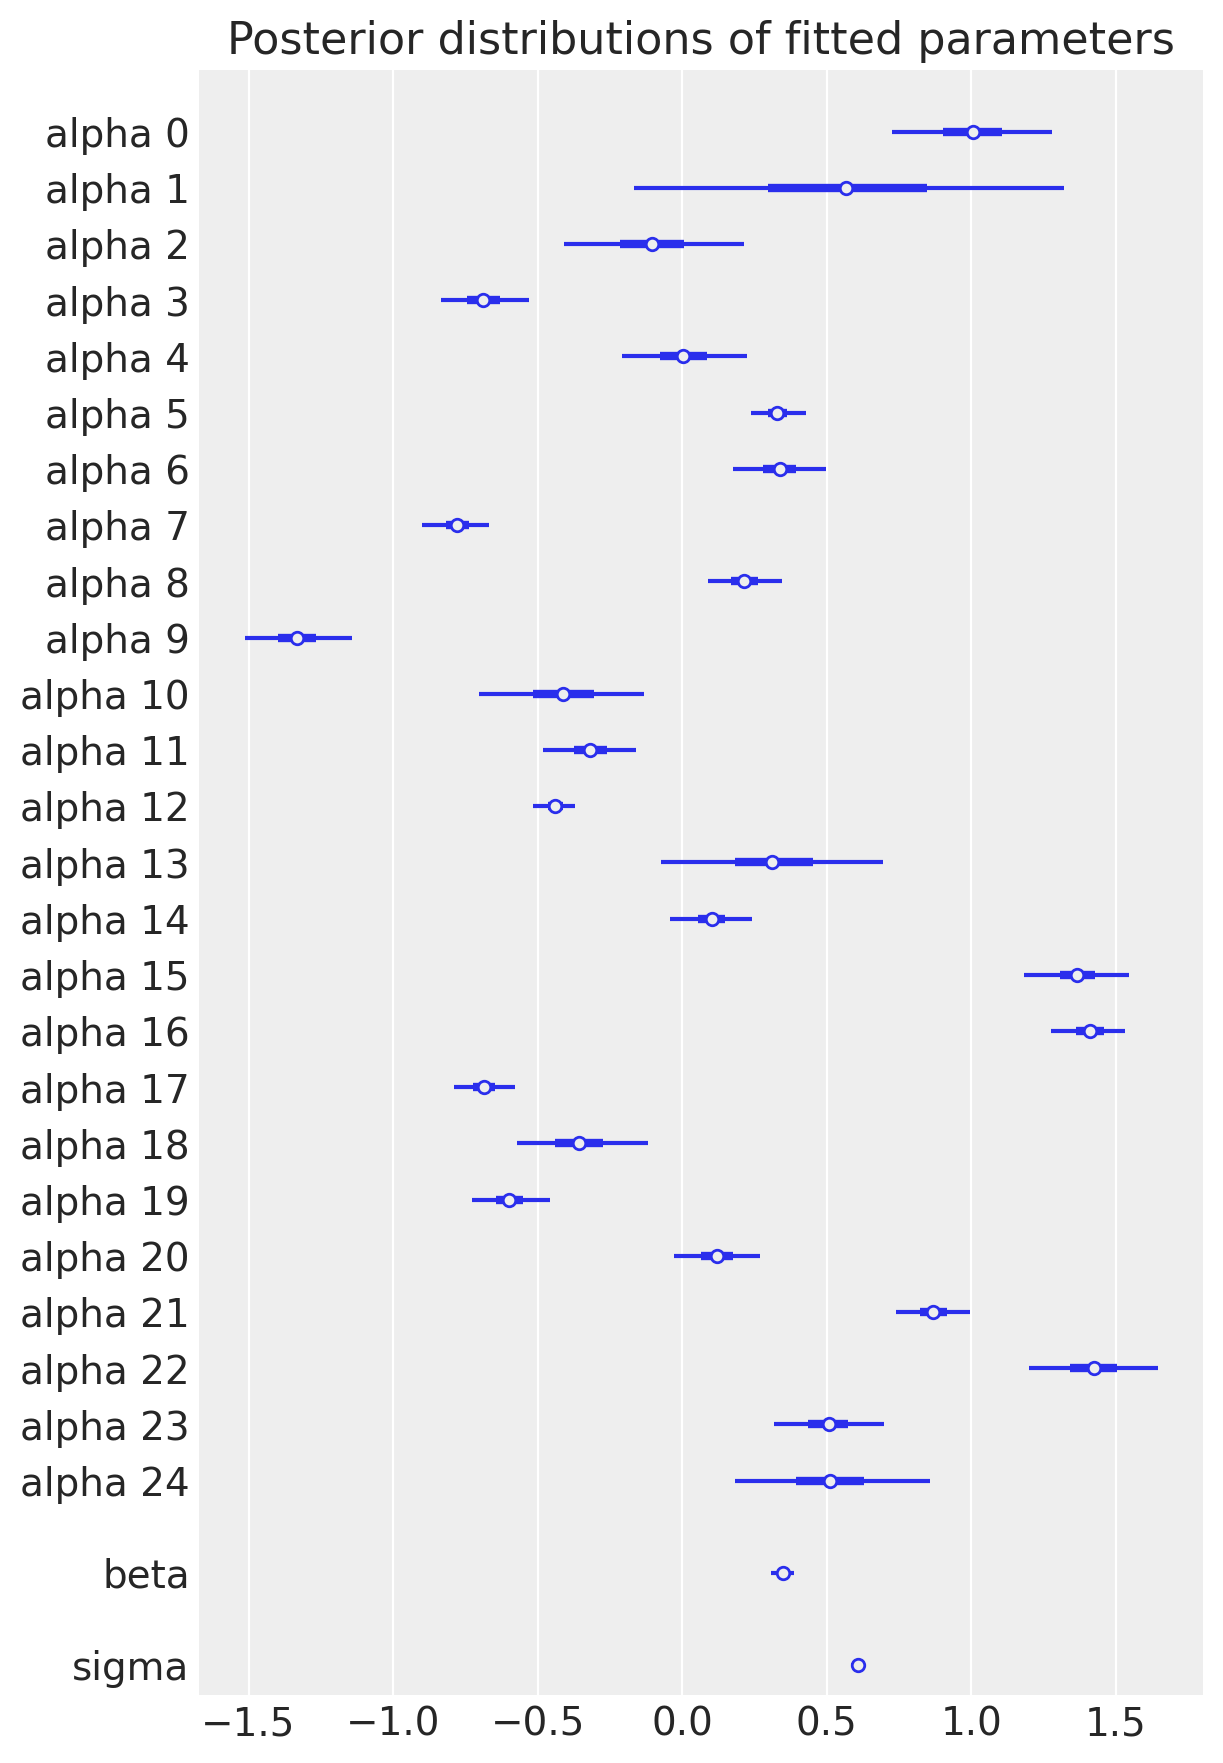

In [29]:
# Inspect model fit
axes = az.plot_forest(fit_npm, 
              var_names=["alpha", "beta", "sigma"],
              combined = True)

axes[0].set_title('Posterior distributions of fitted parameters')

In [30]:
print(pystan.stansummary(fit_npm, 
                         pars=['alpha', 'beta', 'sigma'], 
                         probs=(0.025, 0.50, 0.975), 
                         digits_summary=3))

Inference for Stan model: anon_model_14f4fc944867a1a0ed7c8160d1d42f4f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]   1.005   0.002  0.148  0.714  1.004  1.296   7145  0.999
alpha[2]    0.57   0.004  0.399 -0.222  0.565  1.342   8135  0.999
alpha[3]  -0.103   0.002  0.166 -0.426 -0.103  0.225   6259  0.999
alpha[4]  -0.687 9.24e-4  0.083 -0.851 -0.688 -0.529   8111    1.0
alpha[5]   0.004   0.002  0.116  -0.22  0.003  0.231   5842  0.999
alpha[6]    0.33 5.46e-4   0.05   0.23  0.329  0.427   8380  0.999
alpha[7]   0.337 9.68e-4  0.084  0.169  0.338  0.504   7614  0.999
alpha[8]  -0.778 6.31e-4  0.062 -0.901 -0.779 -0.653   9534    1.0
alpha[9]   0.216 7.22e-4  0.069  0.081  0.215  0.352   9033    1.0
alpha[10] -1.332 9.76e-4  0.098 -1.527 -1.332 -1.138  10177  0.999
alpha[11]  -0.41   0.002  0.155 -0.706 -0.411  -0.11   6536  0.999
alpha[1

### 7) Posterior predictive check to evaluate model performance


<AxesSubplot:xlabel='log_sales_price / y_hat'>

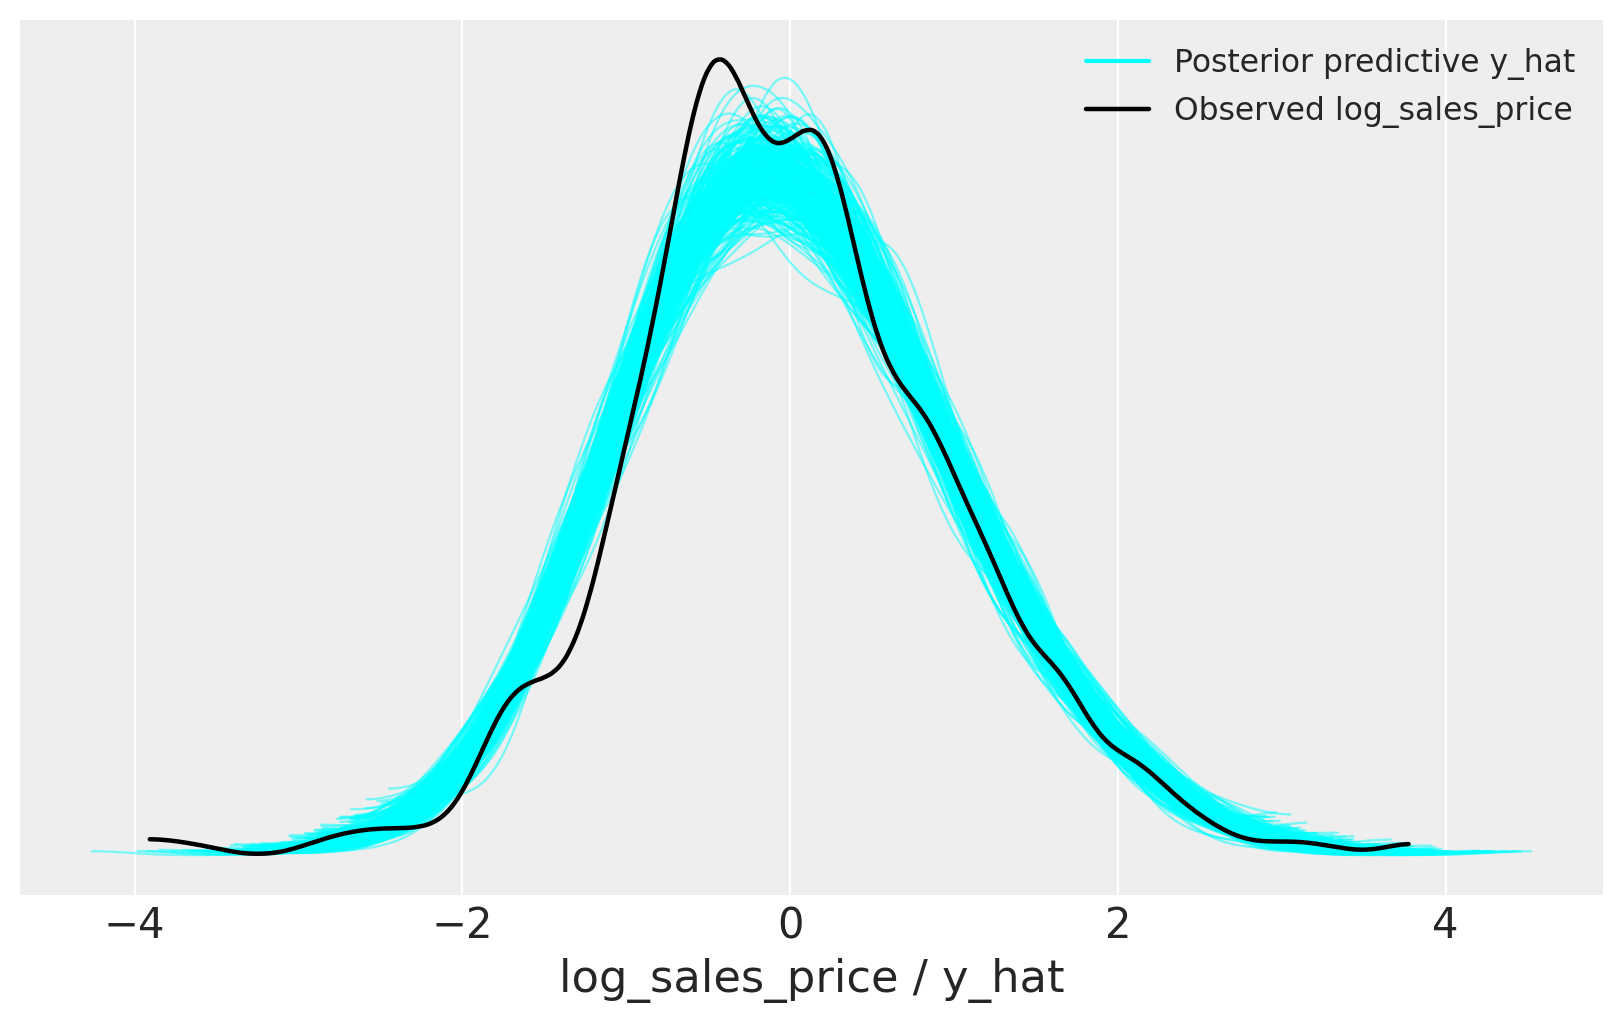

In [37]:
az.plot_ppc(data = npm_az, 
            kind = 'kde', 
            data_pairs = {'log_sales_price' : 'y_hat'},
            legend = True,
            color='cyan',
            mean = False,
            figsize=(8, 5),
            alpha = 0.5,
            num_pp_samples=300)

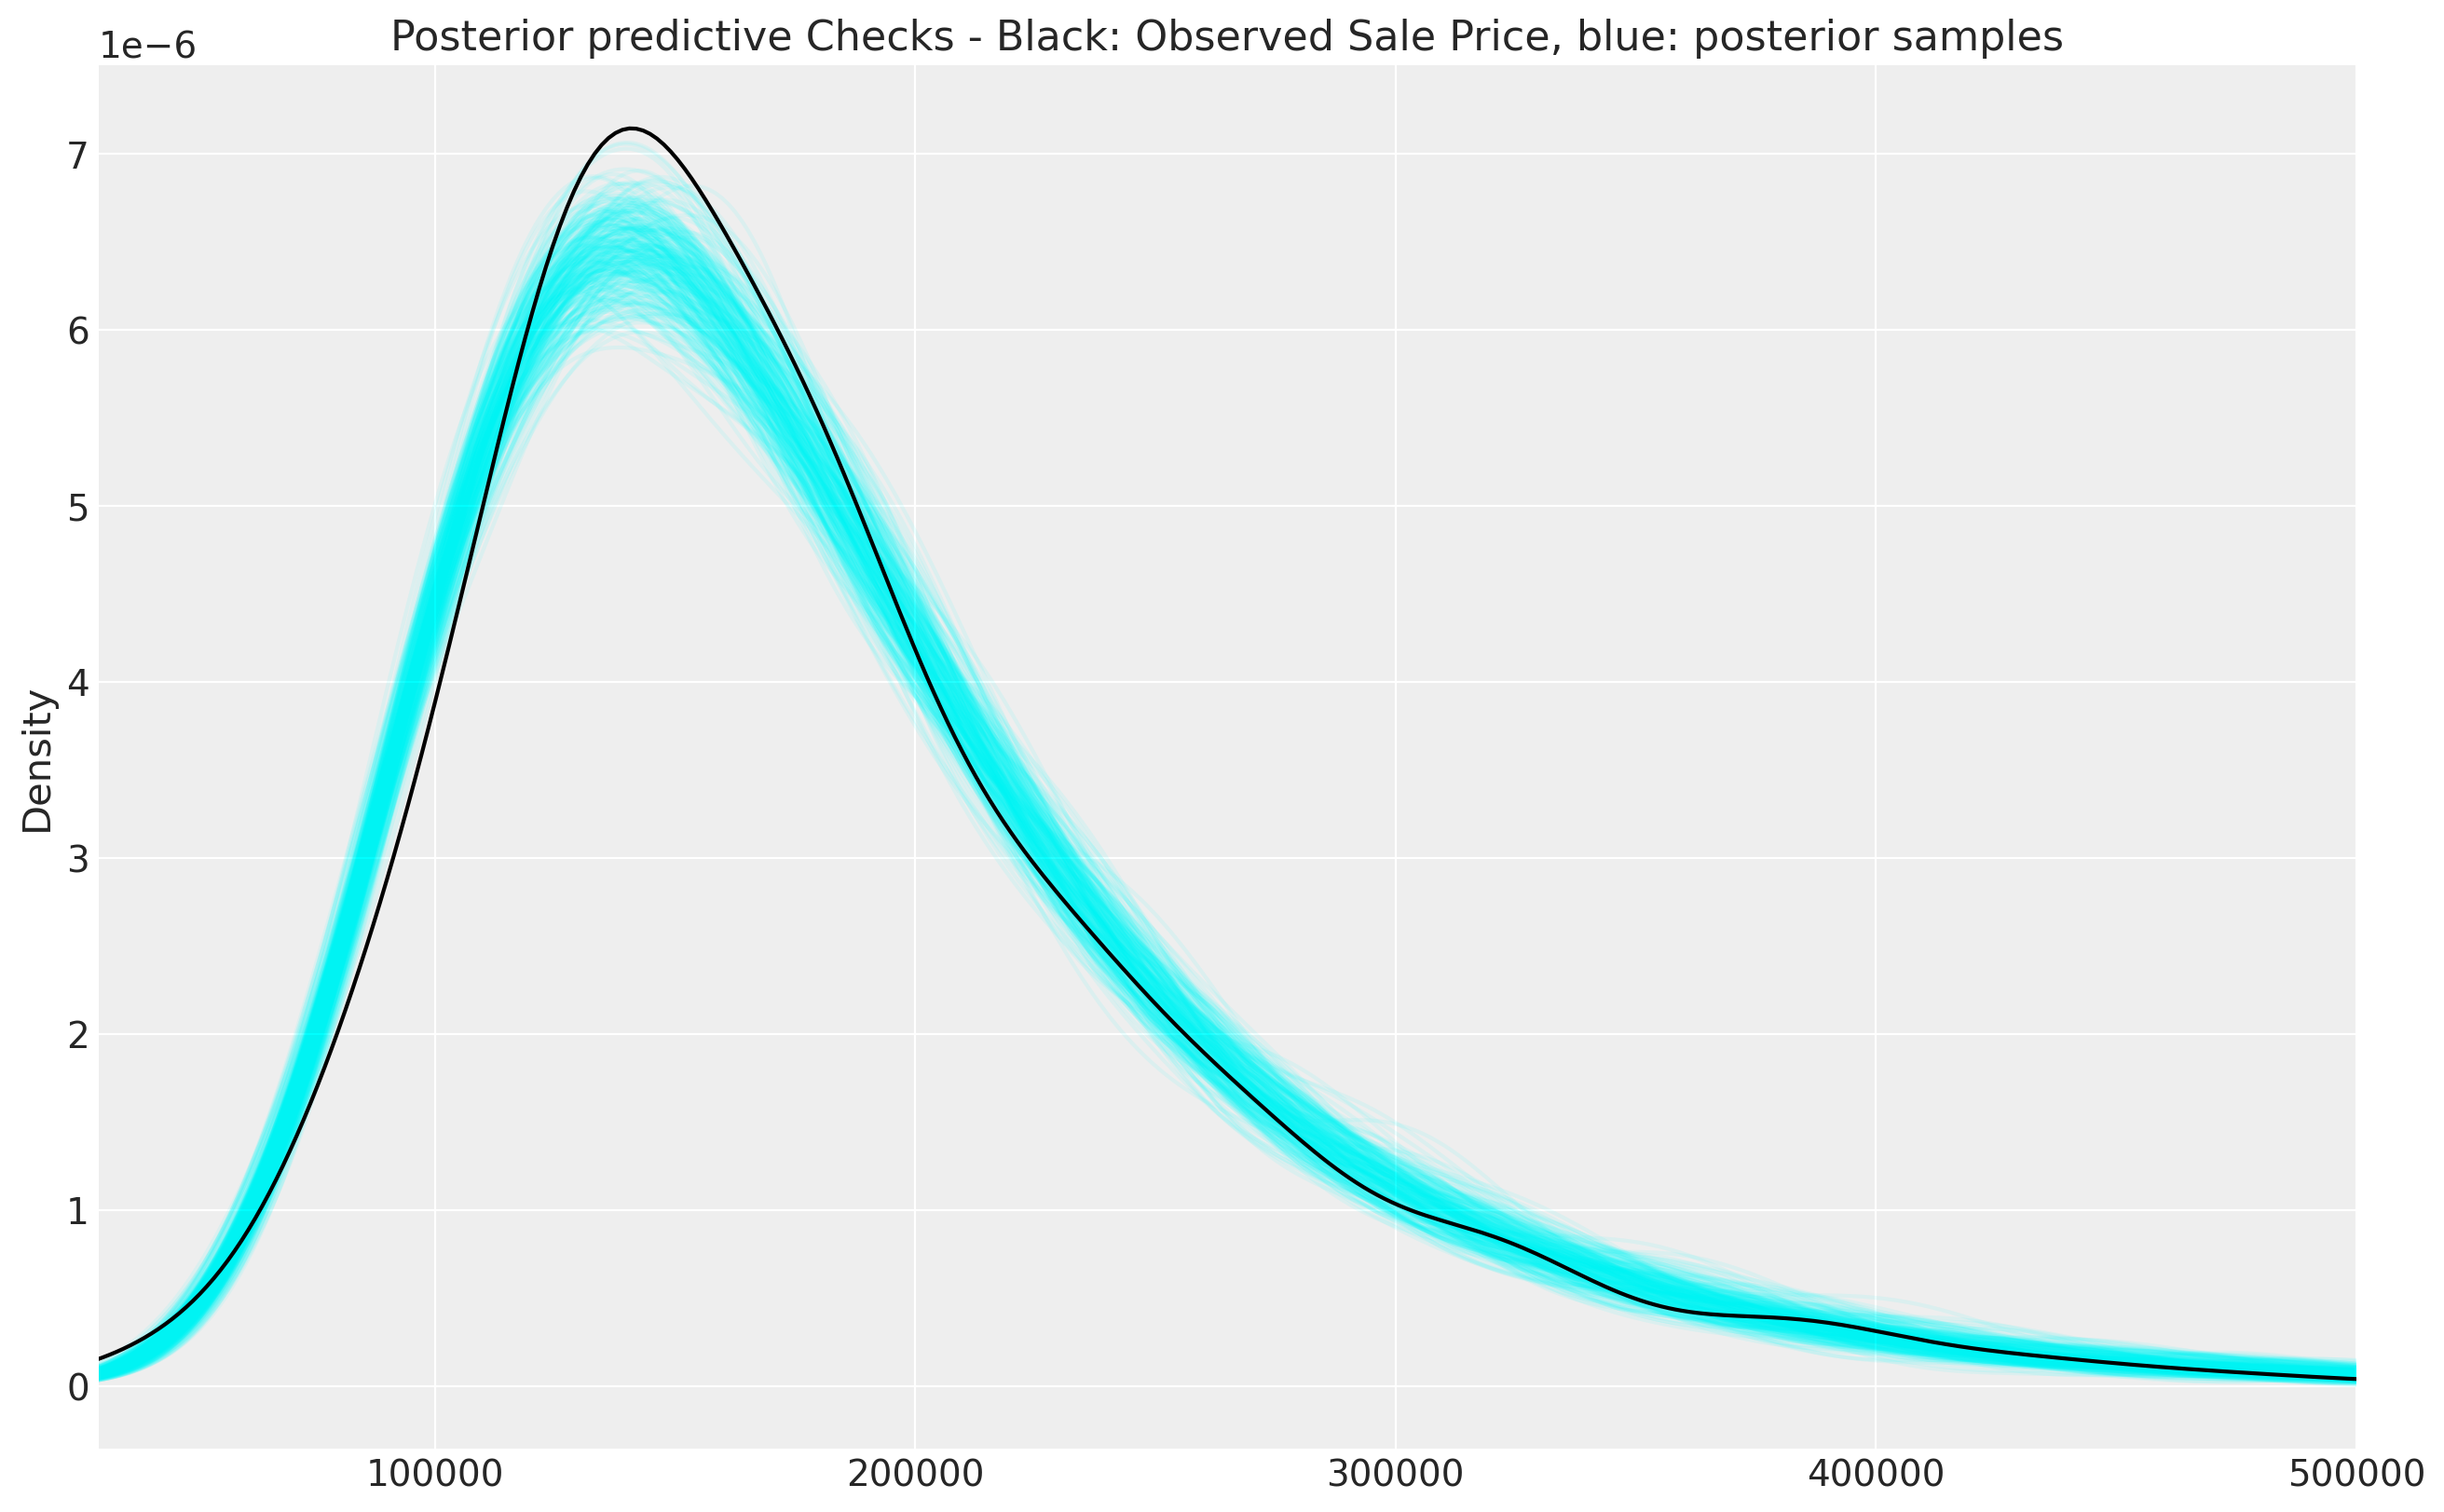

In [36]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))
np.exp(fit_npm_df.filter(regex = 'y_hat')*df['log_sales_price'].std()+df['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predictive Checks - Black: Observed Sale Price, blue: posterior samples', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.08,
                                                                                                  ax = axes, color = 'aqua');

df['SalePrice'].plot.kde(legend = False, 
                         xlim = (30000,500000),
                         alpha = 1,
                         ax = axes,
                         color = 'black');


In [40]:
%load_ext watermark
%watermark -n -v -u -iv -w -a Benjamin_Wee

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
arviz   0.10.0
numpy   1.19.1
pandas  1.1.3
seaborn 0.11.0
pystan  2.19.0.0
Benjamin_Wee 
last updated: Thu Nov 12 2020 

CPython 3.6.12
IPython 5.8.0
watermark 2.0.2
